**Thinking1:新零售中的“人、货、场”分别指什么？**

人：人群划分（用户画像），重点关注增长明显的群体
货：产品划分，不同类的产品采用不同的策略（定价、搭配、仓储配送、供应链管理）
场：消费场所，最不同的购物场景采用不同的优化方案（渠道、页面、不同店面、城市、商圈）

**Thinking2：AIPL与传统的品牌资产评估有何区别？**

AIPL将品牌消费人群进行划分，不同人群的价值是不一样的，可以进行不同的营销策略。

**Thinking3：请列举一例生活工作中存在的帕累托法则**

80%的人只去20%的餐馆就餐

**Thinking4：请简述GBDT与XGBoost的区别？**

1. GBDT是一类机器学习算法，XGBoost是具体的工程实现
2. XGBoost加入正则项控制模型复杂度，有利于防止过拟合
3. GBDT只使用了一阶导数信息，XGBoost对代价函数进行二阶展开，同时使用一阶和二阶导数
4. 传统GBDT在每轮迭代时会使用全部数据，XGBoost支持对数据进行采样
5. GBDT不能处理缺失值，XGBoost能自动学习出缺失值的处理策略

**Thinking5：如何处理神经网络中的过拟合问题？**

1. 加入正则项L1/L2
2. dropout
3. 降低模型复杂度
4. Early stop
5. 数据增广

**Action1：智能供应链分析 数据集：SupplyChainDataset.csv，供应链采购数据**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# 数据加载
path = 'L16/SupplyChain/'
dataset = pd.read_csv(path+'SupplyChain.csv', encoding='unicode_escape')

In [3]:
# 数据补全
dataset['Customer Zipcode'].fillna(dataset['Customer Zipcode'].mode()[0], inplace=True)

<AxesSubplot:title={'center':'Sales in Different Market'}, xlabel='Market'>

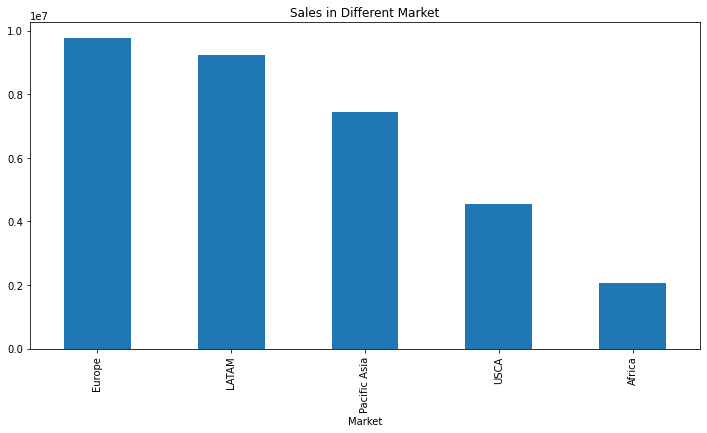

In [4]:
# 按照不同的market
market = dataset.groupby('Market')
market['Sales per customer'].sum().sort_values(ascending=False).plot.bar(figsize=(12,6), title='Sales in Different Market')

<AxesSubplot:title={'center':'Sales in Different Region'}, xlabel='Order Region'>

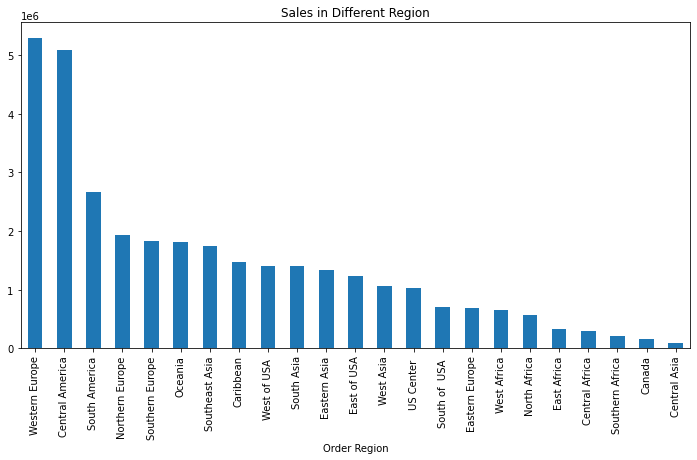

In [5]:
# 按照不同的region
region = dataset.groupby('Order Region')
region['Sales per customer'].sum().sort_values(ascending=False).plot.bar(figsize=(12,6), title='Sales in Different Region')

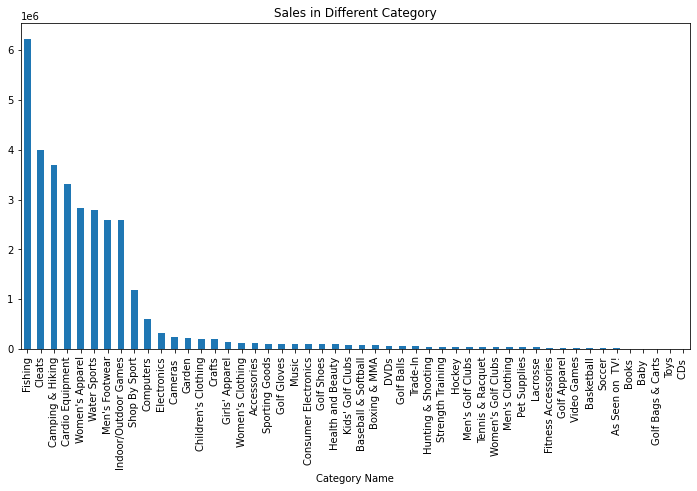

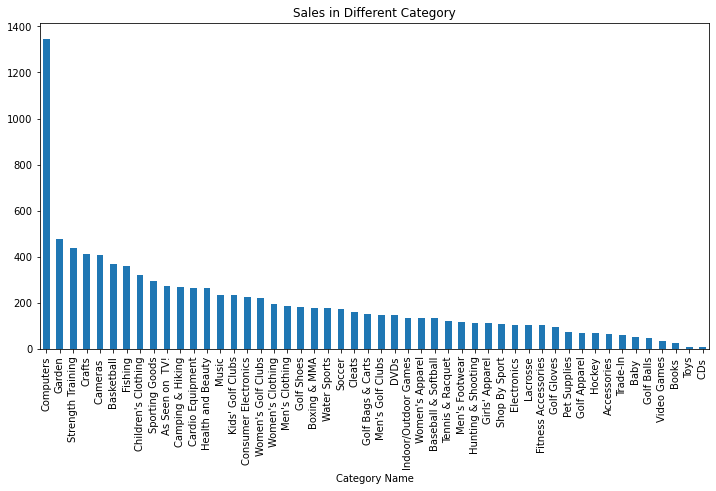

In [6]:
# 按照不同的category
category = dataset.groupby('Category Name')
category['Sales per customer'].sum().sort_values(ascending=False).plot.bar(figsize=(12,6), title='Sales in Different Category')
plt.show()
category['Sales per customer'].mean().sort_values(ascending=False).plot.bar(figsize=(12,6), title='Sales in Different Category')
plt.show()

In [7]:
# 不同时间维度的趋势
temp = pd.DatetimeIndex(dataset['order date (DateOrders)'])

In [8]:
dataset['order_year'] = temp.year
dataset['order_month'] = temp.month
dataset['order_week_day'] = temp.weekday
dataset['order_hour'] = temp.hour

<AxesSubplot:title={'center':'Mean Sales in Hours'}, xlabel='order_hour'>

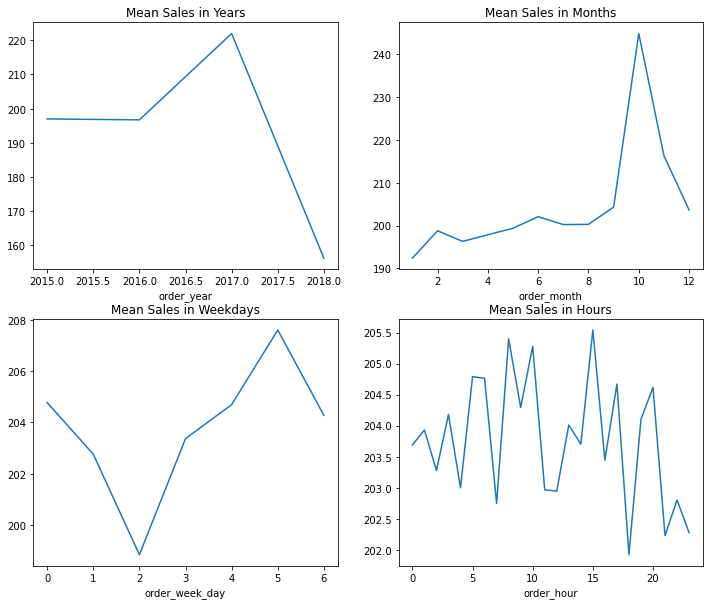

In [9]:
plt.figure(figsize=(12,10))
plt.subplot(2,2,1)
df_year = dataset.groupby('order_year')
df_year['Sales'].mean().plot(title='Mean Sales in Years')

plt.subplot(2,2,2)
df_month = dataset.groupby('order_month')
df_month['Sales'].mean().plot(title='Mean Sales in Months')

plt.subplot(2,2,3)
df_weekday = dataset.groupby('order_week_day')
df_weekday['Sales'].mean().plot(title='Mean Sales in Weekdays')

plt.subplot(2,2,4)
df_hour = dataset.groupby('order_hour')
df_hour['Sales'].mean().plot(title='Mean Sales in Hours')

**用户分层RFM**

In [10]:
dataset['order date (DateOrders)'] = pd.to_datetime(dataset['order date (DateOrders)'])
dataset['order date (DateOrders)'].max()

Timestamp('2018-01-31 23:38:00')

In [11]:
import datetime
now = dataset['order date (DateOrders)'].max()

customer_seg = dataset.groupby('Customer Id').agg({'order date (DateOrders)': lambda x:(now-x.max()).days,
                                                  'Order Id': lambda x: len(x), 
                                                   'Sales': lambda x: x.sum()})
customer_seg.columns=['R_value', 'F_value', 'M_value']

In [12]:
# 划分为2个尺度
quantiles = customer_seg.quantile(q=[0.5])
quantiles = quantiles.to_dict()
quantiles

{'R_value': {0.5: 159.0},
 'F_value': {0.5: 7.0},
 'M_value': {0.5: 1499.82503324}}

In [13]:
# 每个特征二分类
customer_seg['R_Score'] = customer_seg['R_value'].apply(lambda x: 2 if x<=quantiles['R_value'][0.5] else 1)

customer_seg['F_Score'] = customer_seg['F_value'].apply(lambda x: 2 if x>=quantiles['F_value'][0.5] else 1)

customer_seg['M_Score'] = customer_seg['M_value'].apply(lambda x: 2 if x>=quantiles['M_value'][0.5] else 1)

In [14]:
customer_seg

,R_value,F_value,M_value,R_Score,F_Score,M_Score
Customer Id,,,,,,
1,792,1,499.950012,1,1,1
2,136,10,1819.730034,2,2,2
3,229,18,3537.680094,1,2,2
4,380,14,1719.630030,1,2,2
5,457,7,1274.750023,1,2,1
...,...,...,...,...,...,...
20753,0,1,215.820007,2,1,1
20754,0,1,215.820007,2,1,1
20755,0,1,327.750000,2,1,1


In [15]:
def RFM_user(df):
    if df['R_Score'] == 2 and df['F_Score'] == 2 and df['M_Score'] == 2:
        return '重要价值用户'
    if df['R_Score'] == 2 and df['F_Score'] == 1 and df['M_Score'] == 2:
        return '重要发展用户'
    if df['R_Score'] == 1 and df['F_Score'] == 2 and df['M_Score'] == 2:
        return '重要保持用户'
    if df['R_Score'] == 1 and df['F_Score'] == 1 and df['M_Score'] == 2:
        return '重要挽留用户'
    if df['R_Score'] == 2 and df['F_Score'] == 2 and df['M_Score'] == 1:
        return '一般价值用户'
    if df['R_Score'] == 2 and df['F_Score'] == 1 and df['M_Score'] == 1:
        return '一般发展用户'
    if df['R_Score'] == 1 and df['F_Score'] == 2 and df['M_Score'] == 1:
        return '一般保持用户'
    if df['R_Score'] == 1 and df['F_Score'] == 1 and df['M_Score'] == 1:
        return '一般挽留用户'

In [16]:
customer_seg['Customer_Type'] = customer_seg.apply(RFM_user, axis=1)

In [17]:
customer_seg

,R_value,F_value,M_value,R_Score,F_Score,M_Score,Customer_Type
Customer Id,,,,,,,
1,792,1,499.950012,1,1,1,一般挽留用户
2,136,10,1819.730034,2,2,2,重要价值用户
3,229,18,3537.680094,1,2,2,重要保持用户
4,380,14,1719.630030,1,2,2,重要保持用户
5,457,7,1274.750023,1,2,1,一般保持用户
...,...,...,...,...,...,...,...
20753,0,1,215.820007,2,1,1,一般发展用户
20754,0,1,215.820007,2,1,1,一般发展用户
20755,0,1,327.750000,2,1,1,一般发展用户
